<a href="https://colab.research.google.com/github/Ashu156/Neural-time-series-analysis-LFP/blob/main/Event_related_PAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initialize and import required libraries
!pip install tensorpac
import os
import urllib

import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

import matplotlib.pyplot as plt

In [ ]:
# Import data file from local machine
from google.colab import files
uploaded = files.upload()

Saving seeg_data_pac.npz to seeg_data_pac.npz


In [ ]:
# Load data
arch = np.load(filename)
data = arch['data']       # data of a single sEEG contact
sf = float(arch['sf'])    # sampling frequency
times = arch['times']     # time vector
print(f"DATA: (n_trials, n_times)={data.shape}; SAMPLING FREQUENCY={sf}Hz; "
      f"TIME VECTOR: n_times={len(times)}")

DATA: (n_trials, n_times)=(160, 4001); SAMPLING FREQUENCY=1024.0Hz; TIME VECTOR: n_times=4001


In [ ]:
# Function for adding the sections rest / planning / execution to each figure
def add_motor_condition(y_text, fontsize=14, color='k', ax=None):
    x_times = [-.5, 0.750, 2.250]
    x_conditions = ['REST', 'MOTOR\nPLANNING', 'MOTOR\nEXECUTION']
    if ax is None: ax = plt.gca()  # noqa
    plt.sca(ax)
    plt.axvline(0., lw=2, color=color)
    plt.axvline(1.5, lw=2, color=color)
    for x_t, t_t in zip(x_times, x_conditions):
        plt.text(x_t, y_text, t_t, color=color, fontsize=fontsize, ha='center',
                 va='center', fontweight='bold')

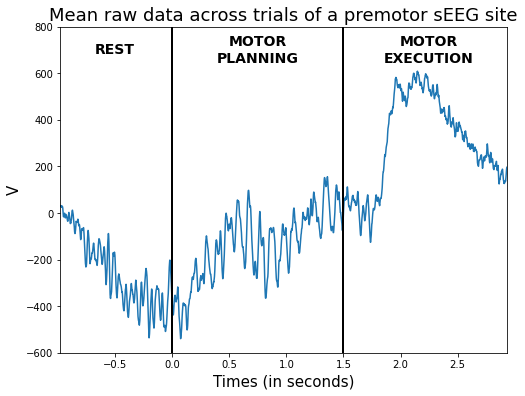

In [ ]:
# Plot raw data for different phases of behavior
plt.figure(figsize=(8, 6))
plt.plot(times, data.mean(0))
plt.autoscale(axis='x', tight=True)
plt.title("Mean raw data across trials of a premotor sEEG site", fontsize=18)
plt.xlabel('Times (in seconds)', fontsize=15)
plt.ylabel('V', fontsize=15)
plt.ylim(-600, 800)
add_motor_condition(700.)
plt.show()





Inter-Trials Coherence (ITC)
    extracting 85 phases


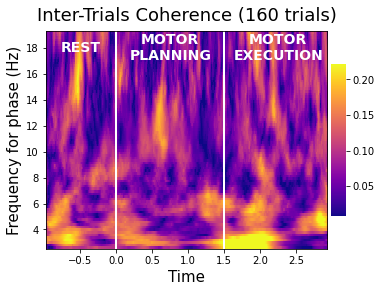

In [ ]:
# Compute and plot inter-trial coherence (ITC)

itc = ITC(data, sf, f_pha=(2, 20, 1, .2))
itc.plot(times=times, cmap='plasma', fz_labels=15, fz_title=18)
add_motor_condition(18, color='white')
plt.show()

Compute PSD over 160 trials and 4001 time points
    Add 95th confidence interval


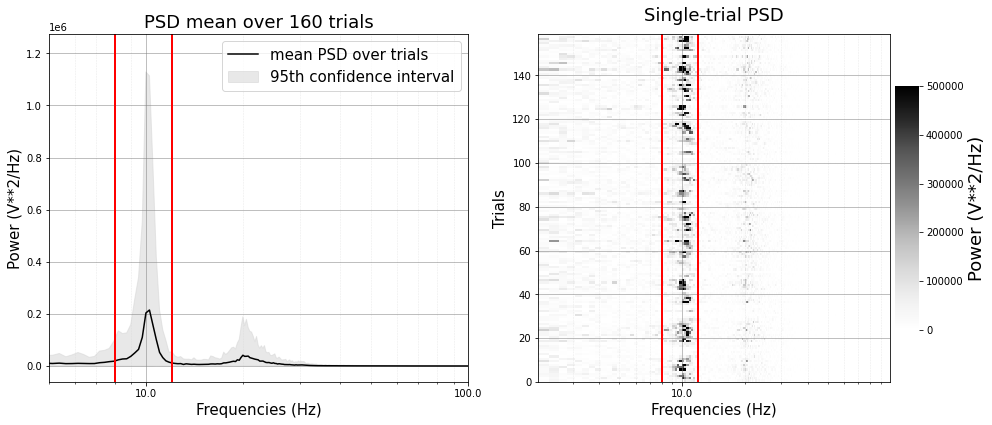

In [ ]:
# Compute and plot the power spectral density

psd = PSD(data, sf)

plt.figure(figsize=(14, 6))
# adding the mean PSD over trials
plt.subplot(1, 2, 1)
ax = psd.plot(confidence=95, f_min=5, f_max=100, log=True, grid=True)
plt.axvline(8, lw=2, color='red')
plt.axvline(12, lw=2, color='red')
# adding the single trial PSD
plt.subplot(1, 2, 2)
psd.plot_st_psd(cmap='Greys', f_min=2, f_max=100, vmax=.5e6, vmin=0., log=True,
                grid=True)
plt.axvline(8, lw=2, color='red')
plt.axvline(12, lw=2, color='red')
plt.tight_layout()
plt.show()




Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=50)
    Compute Gaussian-Copula ERPAC


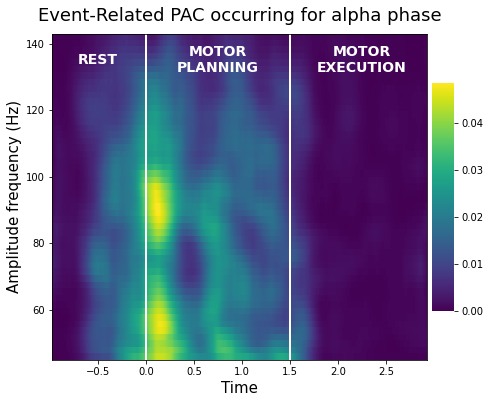

In [ ]:
# Compute and plot the event-related PAC

rp_obj = EventRelatedPac(f_pha=[8, 12], f_amp=(30, 160, 30, 2))
erpac = rp_obj.filterfit(sf, data, method='gc', smooth=100)

plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for alpha phase',
               fz_labels=15, fz_title=18)
add_motor_condition(135, color='white')
plt.show()



PeakLockedTF object defined
    align on time-point=0.0 (sample=999)
    extract phase and amplitudes (n_amps=63)
    running peak detection around sample=999
    realign the 160 phases and amplitudes


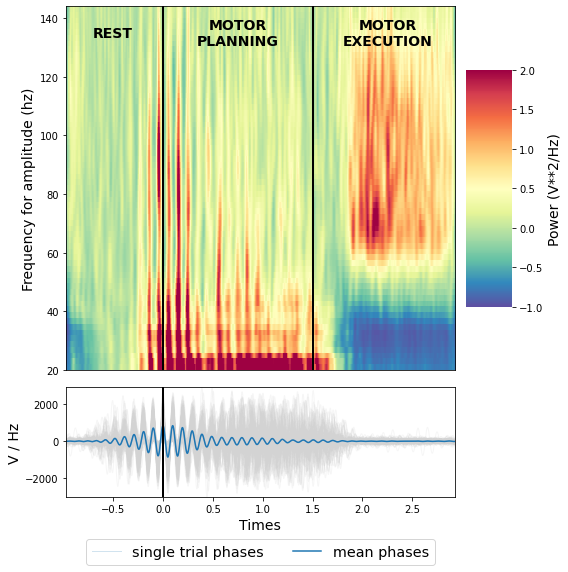

In [ ]:
# Align time-frequency peak based on alpha phase peak

peak = PeakLockedTF(data, sf, 0., times=times, f_pha=[8, 12],
                    f_amp=(5, 160, 30, 2))

plt.figure(figsize=(8, 8))
ax_1, ax_2 = peak.plot(zscore=True, baseline=(250, 750), cmap='Spectral_r',
                       vmin=-1, vmax=2)
add_motor_condition(135, color='black', ax=ax_1)
plt.tight_layout()
plt.show()



In [ ]:
# Compute and compare PAC that is occurring during rest, planning and execution

p_obj = Pac(idpac=(6, 0, 0), f_pha=(6, 14, 4, .2), f_amp=(60, 120, 20, 2))
# extract all of the phases and amplitudes
pha_p = p_obj.filter(sf, data, ftype='phase')
amp_p = p_obj.filter(sf, data, ftype='amplitude')
# define time indices where rest, planning and execution are defined
time_rest = slice(0, 1000)
time_prep = slice(1000, 2500)
time_exec = slice(2500, 4000)
# define phase / amplitude during rest / planning / execution
pha_rest, amp_rest = pha_p[..., time_rest], amp_p[..., time_rest]
pha_prep, amp_prep = pha_p[..., time_prep], amp_p[..., time_prep]
pha_exec, amp_exec = pha_p[..., time_exec], amp_p[..., time_exec]
# compute PAC inside rest, planning, and execution
pac_rest = p_obj.fit(pha_rest, amp_rest).mean(-1)
pac_prep = p_obj.fit(pha_prep, amp_prep).mean(-1)
pac_exec = p_obj.fit(pha_exec, amp_exec).mean(-1)



Phase Amplitude Coupling object defined
    true PAC estimation using Gaussian Copula PAC (gcPac)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    true PAC estimation using Gaussian Copula PAC (gcPac)


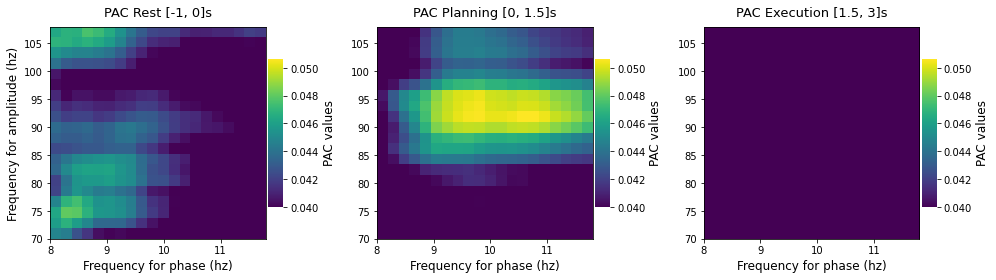

In [ ]:
# Plot the comodulograms
vmax = np.max([pac_rest.max(), pac_prep.max(), pac_exec.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')
plt.figure(figsize=(14, 4))
plt.subplot(131)
p_obj.comodulogram(pac_rest, title="PAC Rest [-1, 0]s", **kw)
plt.subplot(132)
p_obj.comodulogram(pac_prep, title="PAC Planning [0, 1.5]s", **kw)
plt.ylabel('')
plt.subplot(133)
p_obj.comodulogram(pac_exec, title="PAC Execution [1.5, 3]s", **kw)
plt.ylabel('')
plt.tight_layout()
plt.show()



    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=0)
    infer p-values at (p=0.05, mcp=maxstat)
    infer p-values at (p=0.05, mcp=maxstat)


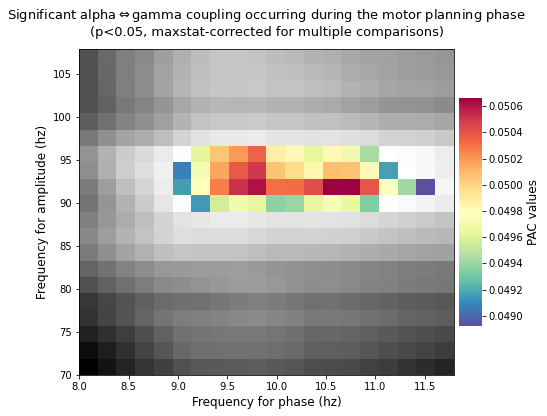

In [ ]:
# Test if alpha-gamma PAC is significant during planning

# still using the Gaussian-Copula PAC but this time, we also select the method
# for computing the permutations
p_obj.idpac = (6, 2, 0)
# compute pac and 200 surrogates
pac_prep = p_obj.fit(pha_p[..., time_prep], amp_p[..., time_prep], n_perm=200,
                     random_state=0)
# get the p-values
mcp = 'maxstat'
pvalues = p_obj.infer_pvalues(p=0.05, mcp=mcp)

# sphinx_gallery_thumbnail_number = 7
plt.figure(figsize=(8, 6))
title = (r"Significant alpha$\Leftrightarrow$gamma coupling occurring during "
         f"the motor planning phase\n(p<0.05, {mcp}-corrected for multiple "
          "comparisons)")
# plot the non-significant pac in gray
pac_prep_ns = pac_prep.mean(-1).copy()
pac_prep_ns[pvalues < .05] = np.nan
p_obj.comodulogram(pac_prep_ns, cmap='gray', vmin=np.nanmin(pac_prep_ns),
                   vmax=np.nanmax(pac_prep_ns), colorbar=False)
# plot the significant pac in color
pac_prep_s = pac_prep.mean(-1).copy()
pac_prep_s[pvalues >= .05] = np.nan
p_obj.comodulogram(pac_prep_s, cmap='Spectral_r', vmin=np.nanmin(pac_prep_s),
                   vmax=np.nanmax(pac_prep_s), title=title)
plt.gca().invert_yaxis()
plt.show()



Binning [75, 105]Hz amplitude according to [8, 12]Hz phase
Binning [75, 105]Hz amplitude according to [8, 12]Hz phase
Binning [75, 105]Hz amplitude according to [8, 12]Hz phase


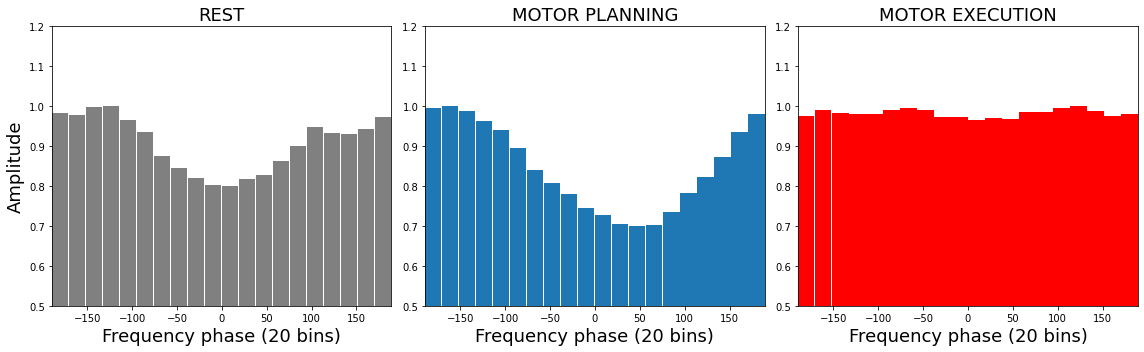

In [ ]:
# Binning gamma amplitude according to alpha phase

# define phase and amplitude filtering properties
kw_filt = dict(f_pha=[8, 12], f_amp=[75, 105], n_bins=20)
# bin the rest, planning and execution periods. Note that ideally, the entire
# trial should be filtered and then binning should be performed
bin_rest = BinAmplitude(data[:, time_rest], sf, **kw_filt)
bin_prep = BinAmplitude(data[:, time_prep], sf, **kw_filt)
bin_exec = BinAmplitude(data[:, time_exec], sf, **kw_filt)

plt.figure(figsize=(16, 5))
# bin rest period
plt.subplot(1, 3, 1)
bin_rest.plot(normalize=True, color='gray', unit='deg')
plt.ylim(0.5, 1.2), plt.title("REST", fontsize=18)
# bin planning period
plt.subplot(1, 3, 2)
bin_prep.plot(normalize=True, unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("MOTOR PLANNING", fontsize=18)
# bin execution period
plt.subplot(1, 3, 3)
bin_exec.plot(normalize=True, color='red', unit='deg')
plt.ylim(0.5, 1.2), plt.ylabel(''), plt.title("MOTOR EXECUTION", fontsize=18)
plt.tight_layout()
plt.show()



Preferred phase object defined


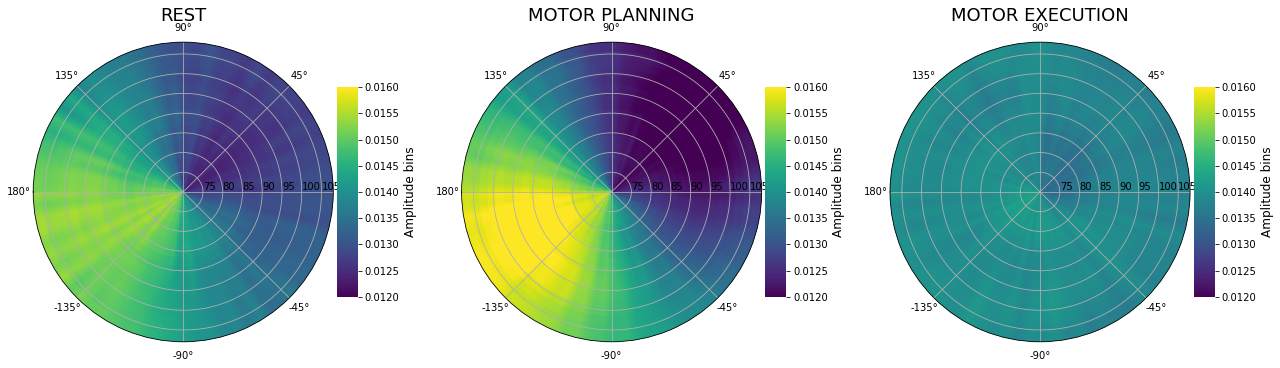

In [ ]:
# Identify the preferred phase

# Define the preferred phase object
pp_obj = PreferredPhase(f_pha=[8, 12])
# only extract the alpha phase
pp_pha = pp_obj.filter(sf, data, ftype='phase')
pp_pha_rest = pp_pha[..., time_rest]
pp_pha_prep = pp_pha[..., time_prep]
pp_pha_exec = pp_pha[..., time_exec]

# Compute the preferred phase (reuse the amplitude computed above)
ampbin_rest, _, vecbin = pp_obj.fit(pp_pha_rest, amp_rest, n_bins=72)
ampbin_prep, _, vecbin = pp_obj.fit(pp_pha_prep, amp_prep, n_bins=72)
ampbin_exec, _, vecbin = pp_obj.fit(pp_pha_exec, amp_exec, n_bins=72)

# Mean binned amplitude across trials
ampbin_rest = np.squeeze(ampbin_rest).mean(-1).T
ampbin_prep = np.squeeze(ampbin_prep).mean(-1).T
ampbin_exec = np.squeeze(ampbin_exec).mean(-1).T

plt.figure(figsize=(18, 5.2))
kw_plt = dict(cmap='viridis', interp=.1, cblabel='Amplitude bins',
              vmin=0.012, vmax=0.016, colorbar=True, y=1.05, fz_title=18)
pp_obj.polar(ampbin_rest, vecbin, p_obj.yvec, subplot=131, title='REST',
             **kw_plt)
pp_obj.polar(ampbin_prep, vecbin, p_obj.yvec, subplot=132,
             title='MOTOR PLANNING', **kw_plt)
pp_obj.polar(ampbin_exec, vecbin, p_obj.yvec, subplot=133,
             title='MOTOR EXECUTION', **kw_plt)
plt.tight_layout()
plt.show()